In [32]:
import os
import numpy as np
import pandas as pd
from pandas import Grouper
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import csv
import warnings
from matplotlib import cm
warnings.filterwarnings("ignore")

In [33]:
# spyq = SPDR ETF quotes (ETFs)
# spyq_trades = SPDR ETF trades (ETFs)

# esm = S&P 500 E-mini quotes (E-mini futures)
# esm_trades = S&P 500 E-mini trades (E-mini futures)

In [34]:
# data loading

#quotes
spyq_quotes = pd.read_csv('SPY-raw-quotes-2010-05-06.csv')
esm_quotes = pd.read_csv('ESM10-quotes-2010-05-06.csv')

#trades
spyq_trades = pd.read_csv('SPY-trades-2010-05-06.csv')
esm_trades = pd.read_csv('ESM10-trades-2010-05-06.csv')

### Data cleaning

In [35]:
def data_cleaning_spyq_quotes(df): 

    #0. Шаблон таблицы с пропусками
    table = {'Code': ['B','C','D','I','M','P','T','W','Z'],
             'Description':['NASDAQ OMX BX, Inc.',
                            'National Stock Exchange Inc. (NSX)',
                            'Financial Industry Regulatory Authority, Inc. (FINRA ADF)',
                            'International Securities Exchange, LLC (ISE)',
                            'Chicago Stock Exchange, Inc. (CHX)',
                            'NYSE Arca, Inc.',
                            'NASDAQ Stock Exchange, LLC (in Tape A, B securities)',
                            'Chicago Broad Options Exchange, Inc.(CBOE)',
                            'Bats BZX Exchange, Inc.']}

    # 1. Delete records with zero price or zero size

    condition_zero = (df['bid'] == 0) | (df['ask'] == 0) | (df['bidsize'] == 0) | (df['asksize'] == 0) 
    df_1 = df[~condition_zero]
    # deleted records for pivot table 
    df_1_del = df[condition_zero].groupby('exchange').count().reset_index()[['exchange','bid']]
    df_1_del.columns = ['Code', 'wrong_price_&_size_1']

    # 2. Delete crossed market and locked market quotes. 

    # First - situation, when bid bigger then ask, second - when they are equal.
    condition_market = (df_1['bid'] >= df_1['ask']) 
    df_2 = df_1[~condition_market]
    # deleted records for pivot table 
    df_2_del = df_1[condition_market].groupby('exchange').count().reset_index()[['exchange','bid']]
    df_2_del.columns = ['Code', 'wrong_market_2']

    # 3. Date transformation to datetime UTC time with US date localization

    df_2['date'] = df_2['date'].astype(str)
    df_2['DateTime'] = df_2['date'].str.cat(df_2['time_m'], sep = ' ')
    df_2['DateTime'] = df_2['DateTime'] = pd.to_datetime(df_2['DateTime'])
    df_2['DateTime'] = df_2['DateTime'].dt.tz_localize('US/Eastern')
    # delete unnecessary columns
    df_3 = df_2.drop(['date', 'time_m', 'sym_root', 'sym_suffix'], axis = 1)
    df_3 = df_3[['DateTime','exchange','bid','ask','bidsize','asksize']]

    # 4. Deleting records outside the time interval

    start = '2010-05-06 09:30:00'
    finish = '2010-05-06 16:00:00'
    condition_time = (df_3['DateTime'] >= start) & (df_3['DateTime'] <= finish)
    df_4 = df_3[condition_time]
    # deleted records for pivot table 
    df_4_del = df_3[~condition_time].groupby('exchange').count().reset_index()[['exchange','bid']]
    df_4_del.columns = ['Code', 'wrong_time_4']

    # 5. Deleting duplicates

    df_5 = df_4.drop_duplicates()
    #deleted records for pivot table 
    df_5_del = df_4.loc[df_4.duplicated()].groupby('exchange').count().reset_index()[['exchange','bid']]
    df_5_del.columns = ['Code', 'duplicates_5']

    # 6. Deleting missings

    df_6 = df_5.dropna().reset_index(drop = True)
    #deleted records for pivot table 
    df_6_del = df_5[df_5.isnull().any(axis=1)].groupby('exchange').count().reset_index()[['exchange','bid']]
    df_6_del.columns = ['Code', 'NA_6']

    # creating pivot table with deleted records
    df_del = pd.DataFrame(table).merge(df_1_del, how = 'left', on = 'Code')
    df_del = df_del.merge(df_2_del, how = 'left', on = 'Code')
    df_del = df_del.merge(df_4_del, how = 'left', on = 'Code')
    df_del = df_del.merge(df_5_del, how = 'left', on = 'Code')
    df_del = df_del.merge(df_6_del, how = 'left', on = 'Code')
    
    return df_6, df_del

def data_cleaning_esm_quotes(df):
    
    df.columns = ['date','bid','bidsize','ask','asksize']
        
    # 1. Delete records with zero price or zero size
    
    condition_zero = (df['bid'] == 0) | (df['ask'] == 0) | (df['bidsize'] == 0) |  (df['asksize'] == 0) 
    df_1 = df[~condition_zero]
    
    # 2. Delete crossed market and locked market quotes.
    # First - situation, when bid bigger then ask, second - when they are equal.

    condition_market = (df_1['bid'] >= df_1['ask']) 
    df_2 = df_1[~condition_market]
        
    # 3. Date transformation to datetime UTC time with US date localization

    df_2['DateTime'] = pd.to_datetime(df_2['date'])
    df_3 = df_2.drop('date', axis = 1)
    df_3 = df_3[['DateTime','bid','ask','bidsize','asksize']]
        
    # 4. Deleting records outside the time interval

    start = '2010-05-06 09:30:00'
    finish = '2010-05-06 16:00:00'
    condition_time = (df_3['DateTime'] >= start) & (df_3['DateTime'] <= finish)
    df_4 = df_3[condition_time]
    
    # 5. Deleting duplicates

    df_5 = df_4.drop_duplicates()
    
    # 6. Deleting missings
    
    df_6 = df_5.dropna().reset_index(drop = True)
    
    return df_6

def data_cleaning_spyq_trades(df):

    df.rename(columns = {'size' : 'volume'}, inplace = True)
        
    # 1. Delete records with zero price or zero size

    condition_zero = (df['price'] == 0) | (df['volume'] == 0)
    df_1 = df[~condition_zero]
            
    # 2, 3. Date transformation to datetime UTC time with US date localization

    df_1['date'] = df_1['date'].astype(str)
    df_1['DateTime'] = df_1['date'].str.cat(df_1['time_m'], sep = ' ')
    df_1['DateTime'] = df_1['DateTime'] = pd.to_datetime(df_1['DateTime'])
    df_1['DateTime'] = df_1['DateTime'].dt.tz_localize('US/Eastern')
    # delete unnecessary columns
    df_2 = df_1.drop(['date', 'time_m', 'sym_root', 'sym_suffix'], axis = 1)
    df_3 = df_2[['DateTime','exchange', 'price', 'volume']]
    
    # 4. Deleting records outside the time interval

    start = '2010-05-06 09:30:00'
    finish = '2010-05-06 16:00:00'
    condition_time = (df_3['DateTime'] >= start) & (df_3['DateTime'] <= finish)
    df_4 = df_3[condition_time]
    
    # 5. Deleting duplicates

    df_5 = df_4.drop_duplicates()

    # 6. Deleting missings
    
    df_6 = df_5.dropna().reset_index(drop = True)

    return df_6

def data_cleaning_esm_trades(df):
    
    df.columns = ['date','price', 'volume']

    # 1. Delete records with zero price or zero size

    condition_zero = (df['price'] == 0) | (df['volume'] == 0)
    df_1 = df[~condition_zero]
            
    # 2, 3. Date transformation to datetime UTC time with US date localization
    
    df_1['DateTime'] = pd.to_datetime(df_1['date'])
    df_2 = df_1.drop('date', axis = 1)
    df_3 = df_2[['DateTime','price', 'volume']]
        
    # 4. Deleting records outside the time interval

    start = '2010-05-06 09:30:00'
    finish = '2010-05-06 16:00:00'
    condition_time = (df_3['DateTime'] >= start) & (df_3['DateTime'] <= finish)
    df_4 = df_3[condition_time]
    
    # 5. Deleting duplicates

    df_5 = df_4.drop_duplicates()
    
    # 6. Deleting missings

    df_6 = df_5.dropna().reset_index(drop = True)
    
    return df_6
    

In [36]:
spyq_quotes_clean, spyq_quotes_del_df = data_cleaning_spyq_quotes(spyq_quotes)
esm_quotes_clean = data_cleaning_esm_quotes(esm_quotes)
spyq_trades_clean = data_cleaning_spyq_trades(spyq_trades)
esm_trades_clean = data_cleaning_esm_trades(esm_trades)

In [37]:
# pivot table with deleted records: SPYQ QUOTES
spyq_quotes_del_df

,Code,Description,wrong_price_&_size_1,wrong_market_2,wrong_time_4,duplicates_5,NA_6
0,B,"NASDAQ OMX BX, Inc.",806.0,NaN,NaN,2495.0,NaN
1,C,National Stock Exchange Inc. (NSX),1738.0,NaN,NaN,901.0,NaN
2,D,"Financial Industry Regulatory Authority, Inc. ...",NaN,NaN,NaN,NaN,NaN
3,I,"International Securities Exchange, LLC (ISE)",1970.0,NaN,NaN,83.0,NaN
4,M,"Chicago Stock Exchange, Inc. (CHX)",6.0,NaN,NaN,435.0,NaN
5,P,"NYSE Arca, Inc.",2.0,NaN,NaN,729387.0,NaN
6,T,"NASDAQ Stock Exchange, LLC (in Tape A, B secur...",NaN,NaN,NaN,4093.0,NaN
7,W,"Chicago Broad Options Exchange, Inc.(CBOE)",1208.0,NaN,NaN,3188.0,NaN
8,Z,"Bats BZX Exchange, Inc.",NaN,NaN,NaN,28754.0,NaN


### Analysis

#### 1 PRICE

In [38]:
# first price of the day
spyq_first_price_of_the_day = spyq_trades_clean.sort_values('DateTime')['price'][0]
esm_first_price_of_the_day = esm_trades_clean.sort_values('DateTime')['price'][0]

# normalization by the first price of the day
spyq_trades_clean['price_norm'] = (spyq_trades_clean['price']*100)/spyq_first_price_of_the_day
esm_trades_clean['price_norm'] = (esm_trades_clean['price']*100)/esm_first_price_of_the_day

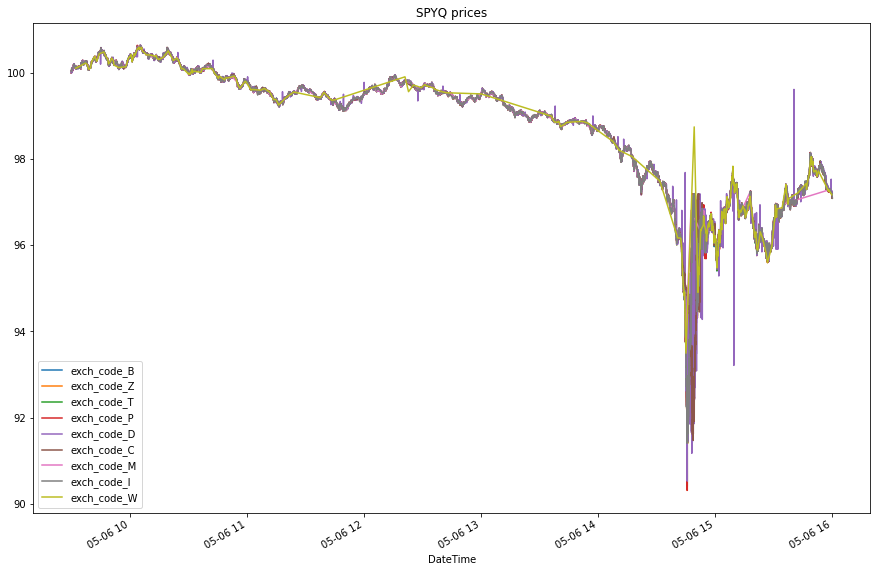

In [39]:
# SPYQ prices by exchanges graph
container = []
for code in spyq_trades_clean['exchange'].unique():
    temp = spyq_trades_clean[spyq_trades_clean['exchange'] == code]
    temp.rename(columns = {'price_norm' : f'exch_code_{code}'}, inplace = True)
    temp_1 = temp[f'exch_code_{code}']
    temp_1.index = temp['DateTime']
    container.append(temp_1)

for i in range(len(container)):
    container[i].plot(figsize = (15,10), legend = True, title = 'SPYQ prices')

In [40]:
#Conclusion:
# 1. We see abnormal price jumps on the D and W exchanges. Whereas exchange M contains low number of records
# and needs to be deleted.
# 2. Evidence of a flash crash between 14:10 and 15:30 

<AxesSubplot:title={'center':'ESM prices'}, xlabel='DateTime'>

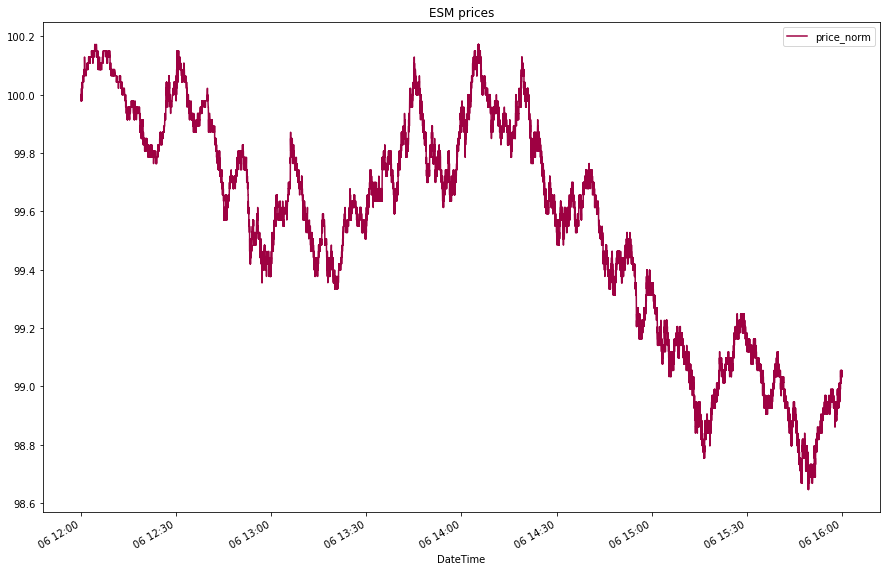

In [41]:
# ESM prices
cmap = cm.get_cmap('Spectral')
esm_trades_clean[['DateTime','price_norm']].plot(x = 'DateTime', y = 'price_norm',figsize = (15,10), legend = True, title = 'ESM prices', colormap = cmap)

In [42]:
# Deleting exchanges D, W, M from analysis
spyq_quotes_clean = spyq_quotes_clean[spyq_quotes_clean['exchange'].isin(['D','W','M']) == False].reset_index(drop = True)
spyq_trades_clean = spyq_trades_clean[spyq_trades_clean['exchange'].isin(['D','W','M']) == False].reset_index(drop = True)

#### 2 VOLUME

In [43]:
# Total daily volumes:
print('Total daily volume SPYQ:',spyq_trades_clean['volume'].sum())
print('Total daily volume S&P 500 E-mini:',esm_trades_clean['volume'].sum())

Total daily volume SPYQ: 381667899
Total daily volume S&P 500 E-mini: 1439363.0


<AxesSubplot:title={'center':'SPYQ cumsum volume'}, xlabel='DateTime'>

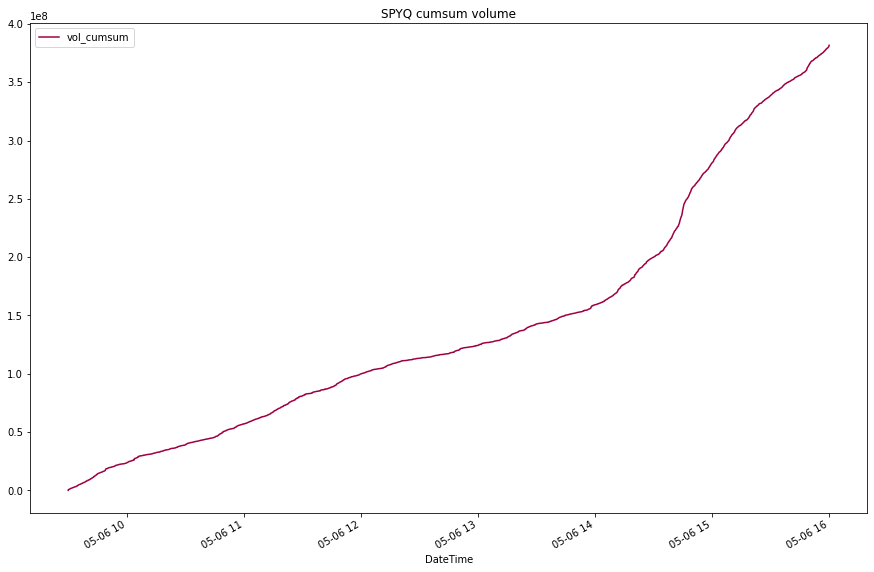

In [44]:
#SPYQ cumsum volume graph
spyq_trades_clean['vol_cumsum'] = spyq_trades_clean['volume'].cumsum()
cumsum_spyq = spyq_trades_clean[['DateTime', 'vol_cumsum']]
cumsum_spyq.plot(x = 'DateTime', y = 'vol_cumsum',figsize = (15,10), legend = True, title = 'SPYQ cumsum volume', colormap = cmap)

<AxesSubplot:title={'center':'ESM cumsum volume'}, xlabel='DateTime'>

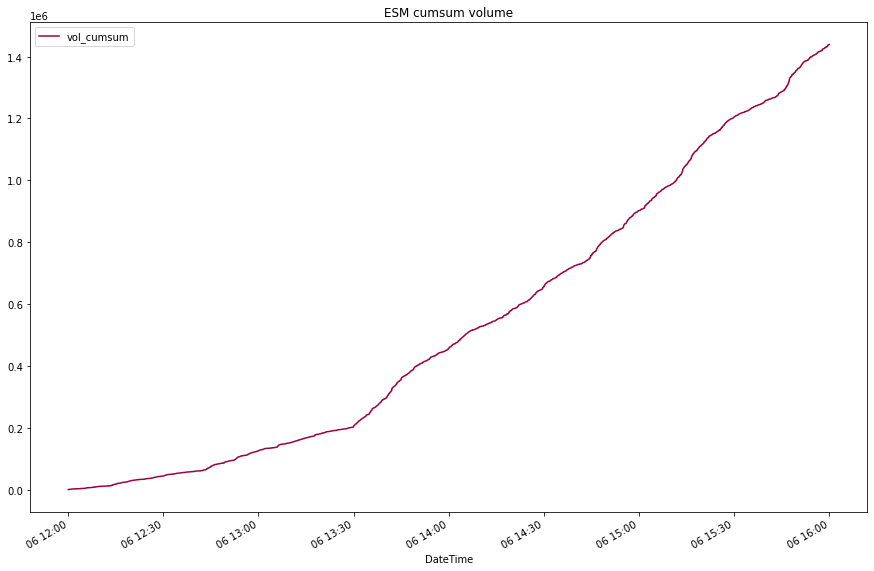

In [45]:
#ESM cumsum volume
esm_trades_clean['vol_cumsum'] = esm_trades_clean['volume'].cumsum()
cumsum_esm = esm_trades_clean[['DateTime', 'vol_cumsum']]
cumsum_esm.plot(x = 'DateTime', y = 'vol_cumsum',figsize = (15,10), legend = True, title = 'ESM cumsum volume', colormap = cmap)

In [46]:
# Conclusion:
# 1. We see a deviation from the trend of cumulative volume growth of SPYQ instrument
# 2. The volume of SPYQ is much higher then ESM because it is represented on several exchanges

#### 3 Defining the Flash Crash

##### Prices during flash crash

In [47]:
def get_crashdat(df, crashbegin, crashend):
    return df[(df['DateTime'] >= crashbegin) & (df['DateTime'] <= crashend)].reset_index(drop = True)

crashbegin = '2010-05-06 14:10:00'; crashend = '2010-05-06 15:30:00'

# spyq and esm during the falsh crash
spyq_trades_clean_flash_crash = get_crashdat(spyq_trades_clean, crashbegin, crashend)
esm_trades_clean_flash_crash = get_crashdat(esm_trades_clean, crashbegin, crashend)

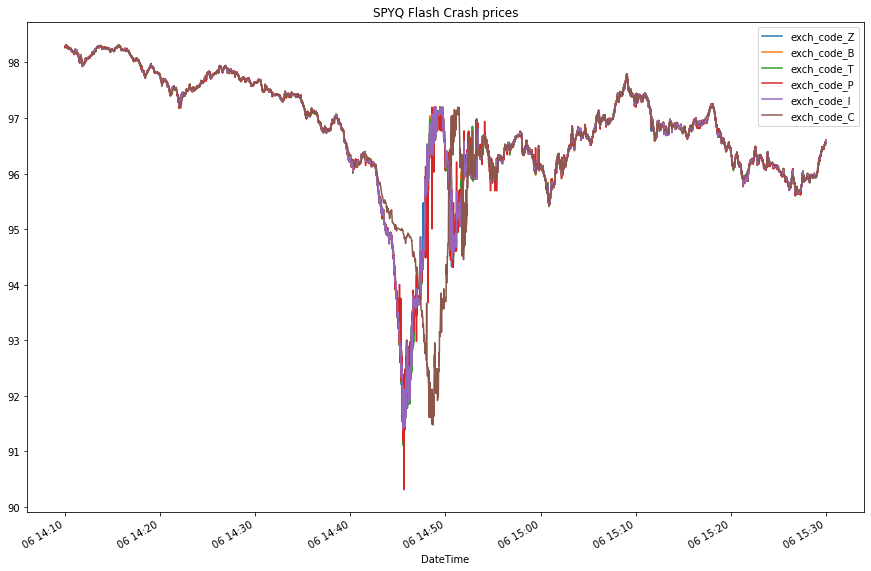

In [48]:
#SPYQ Flash Crash prices 
container = []
for code in spyq_trades_clean_flash_crash['exchange'].unique():
    temp = spyq_trades_clean_flash_crash[spyq_trades_clean_flash_crash['exchange'] == code]
    temp.rename(columns = {'price_norm' : f'exch_code_{code}'}, inplace = True)
    temp_1 = temp[f'exch_code_{code}']
    temp_1.index = temp['DateTime']
    container.append(temp_1)

for i in range(len(container)):
    container[i].plot(figsize = (15,10), legend = True, title = 'SPYQ Flash Crash prices')

<AxesSubplot:title={'center':'ESM Flash Crash prices'}, xlabel='DateTime'>

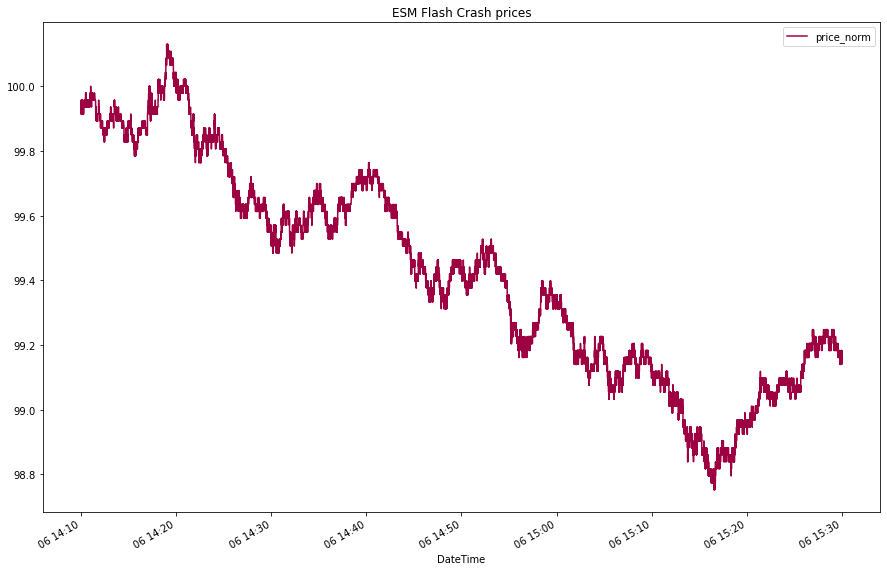

In [49]:
#ESM Flash Crash prices
esm_trades_clean_flash_crash[['DateTime','price_norm']].plot(x = 'DateTime', y = 'price_norm',figsize = (15,10), legend = True, title = 'ESM Flash Crash prices', colormap = cmap)

In [50]:
#Conclusion:
# 1. We see the biggest evidence of flas crash for SPYQ between 14:45 and 15:00
# 2. The greatest effect is seen on exchange P

##### Trade Sizes during flsah crash

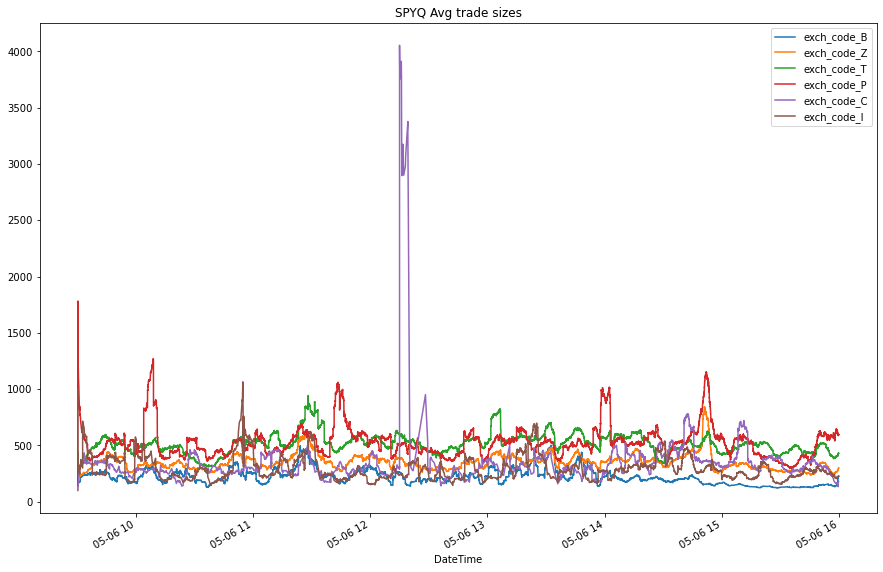

In [51]:
#SPYQ MEAN Trade Size 

container = []
for code in spyq_trades_clean['exchange'].unique():
    temp = spyq_trades_clean[spyq_trades_clean['exchange'] == code]
    temp.rename(columns = {'volume' : f'exch_code_{code}'}, inplace = True)
    temp_1 = temp[f'exch_code_{code}']
    temp_1.index = temp['DateTime']
    temp_2 = temp_1.rolling('5T').mean()
    container.append(temp_2)

for i in range(len(container)):
    container[i].plot(figsize = (15,10), legend = True, title = 'SPYQ Avg trade sizes')

<AxesSubplot:title={'center':'ESM Avg trade sizes'}, xlabel='DateTime'>

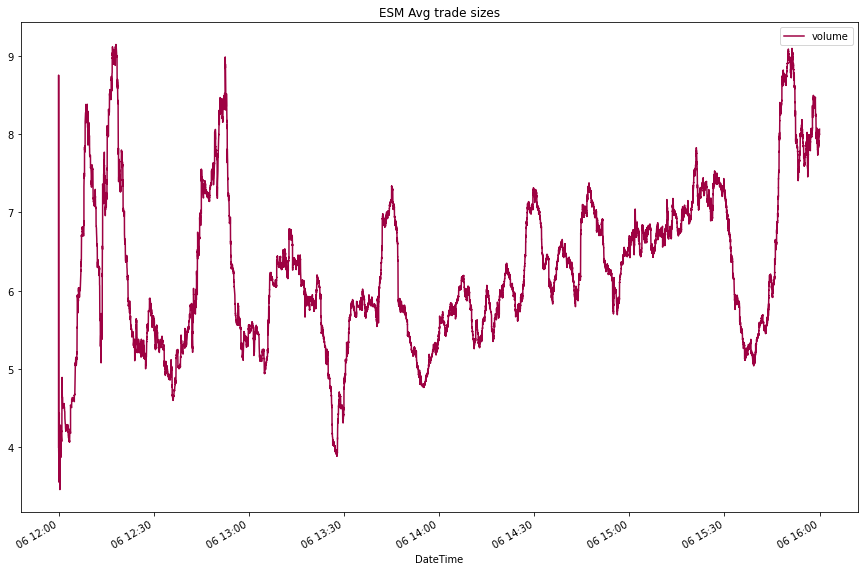

In [52]:
#ESM MEAN Trade Size 
esm_trades_clean_avg_trade_size = esm_trades_clean['volume']
esm_trades_clean_avg_trade_size.index = esm_trades_clean['DateTime']
esm_trades_clean_avg_trade_size.rolling('5T').mean().plot(figsize = (15,10), legend = True, title = 'ESM Avg trade sizes', colormap = cmap)

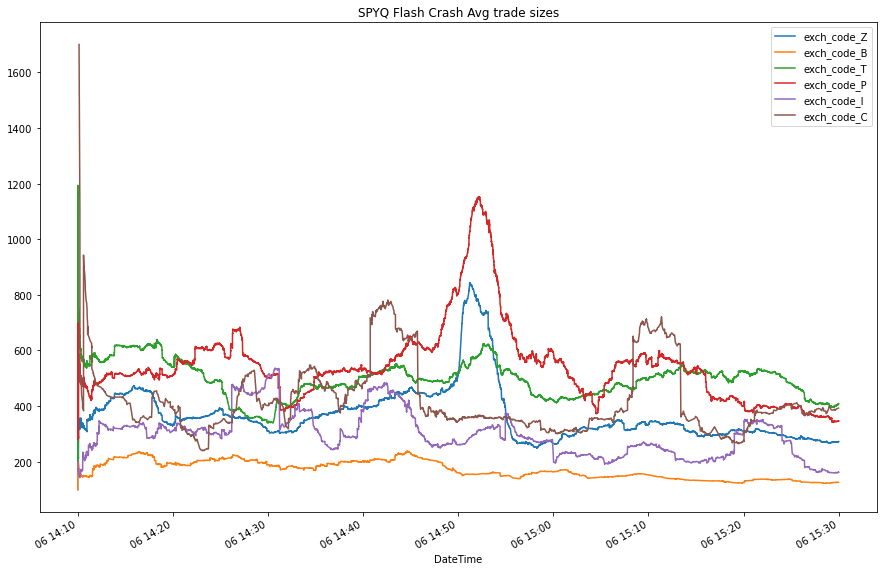

In [53]:
#SPYQ Flash Crash AVG trade sizes 
container = []
for code in spyq_trades_clean_flash_crash['exchange'].unique():
    temp = spyq_trades_clean_flash_crash[spyq_trades_clean_flash_crash['exchange'] == code]
    temp.rename(columns = {'volume' : f'exch_code_{code}'}, inplace = True)
    temp_1 = temp[f'exch_code_{code}']
    temp_1.index = temp['DateTime']
    temp_2 = temp_1.rolling('5T').mean()
    container.append(temp_2)

for i in range(len(container)):
    container[i].plot(figsize = (15,10), legend = True, title = 'SPYQ Flash Crash Avg trade sizes')


<AxesSubplot:title={'center':'ESM Flash Crash Avg trade sizes'}, xlabel='DateTime'>

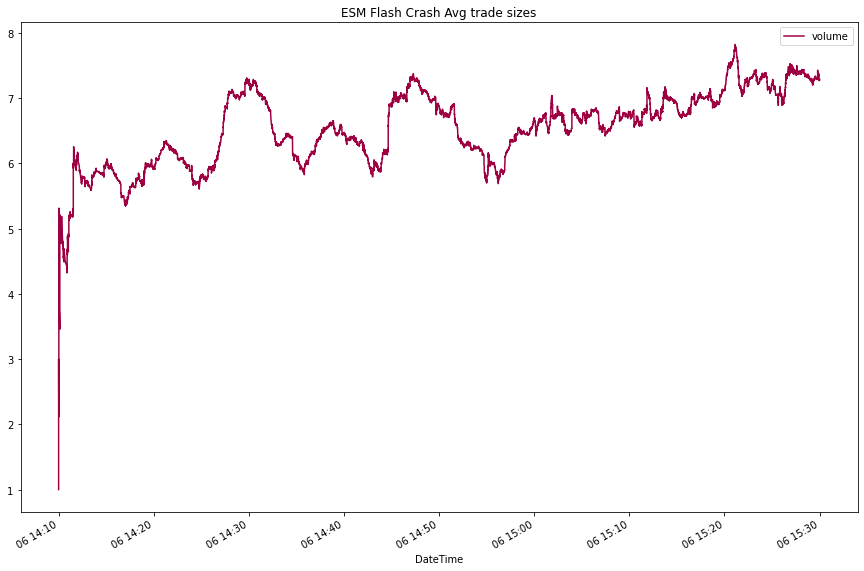

In [54]:
#ESM Flash Crash Avg Trade Size 
esm_trades_clean_flash_crash_avg_trade_size = esm_trades_clean_flash_crash['volume']
esm_trades_clean_flash_crash_avg_trade_size.index = esm_trades_clean_flash_crash['DateTime']
esm_trades_clean_flash_crash_avg_trade_size.rolling('5T').mean().plot(figsize = (15,10), legend = True, title = 'ESM Flash Crash Avg trade sizes', colormap = cmap)

#### 4. Volatility

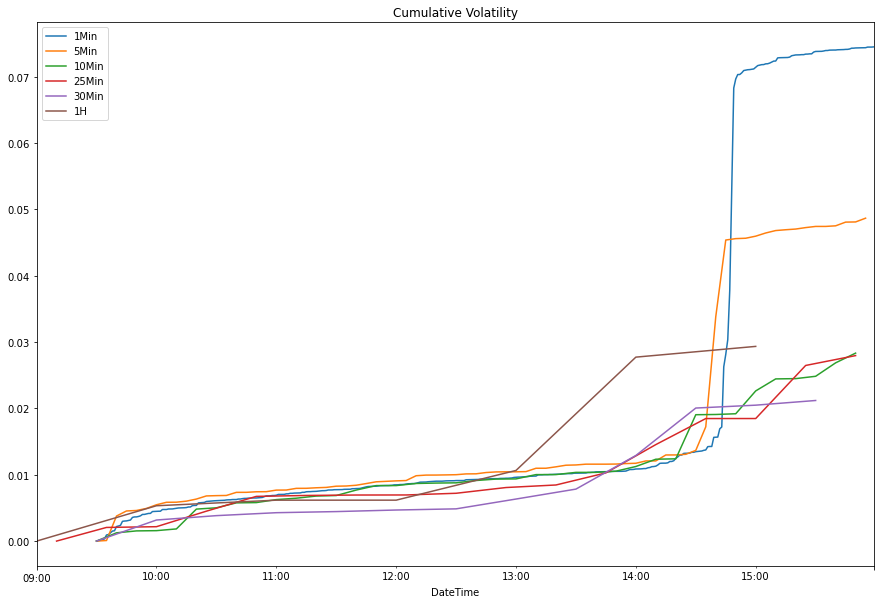

In [55]:
# SPYQ volatility

# volatility detection 
def find_rv(df: pd.DataFrame, freq: str):
    lastprc = df.groupby(pd.Grouper(key='DateTime', freq=freq))['price'].last()
    rv = np.sqrt((np.log(lastprc).diff().fillna(0)**2).cumsum())
    return rv

frequincies = ['1Min', '5Min', '10Min', '25Min', '30Min', '1H']

for freq in frequincies:
    rv = find_rv(spyq_trades_clean, freq = freq)
    rv = rv.rename(freq)
    rv.plot(figsize = (15,10), legend = True, title = 'Cumulative Volatility')

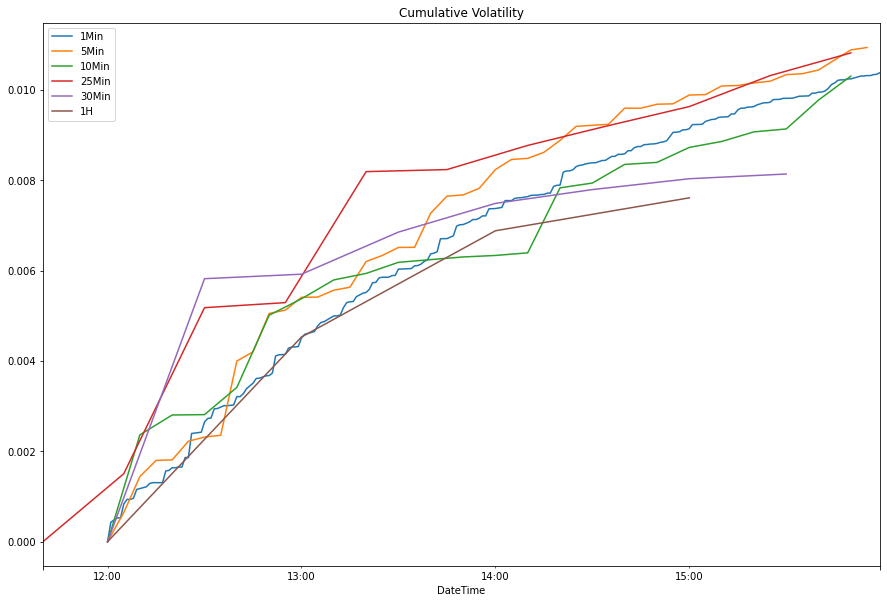

In [56]:
#ESM volatility 
for freq in frequincies:
    rv = find_rv(esm_trades_clean, freq = freq)
    rv = rv.rename(freq)
    rv.plot(figsize = (15,10), legend = True, title = 'Cumulative Volatility')

In [57]:
# Conclusion:
# The biggest volatility is seen for 1min and 5min intervals